In [240]:
import os
import pandas as pd
import seaborn as sns

sns.set()

In [241]:
fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/677758" # True
# fs = "/mnt/weka/home/kyle.chickering/code/nanoGPT/coord-check-impl/640150" # False

dfs = []
for root, dirs, files in os.walk(fs):
    for f in files:
        try:
            if ".csv" in f:
                dfs.append(pd.read_csv(os.path.join(root, f)))
        except Exception as e:
            print(f"Error reading {f}: {e}")

df = pd.concat(dfs, ignore_index=True)

df.dropna(inplace=True)

df['n_experts'] = df['tag'].apply(lambda x: int(x.split('_')[0]))
df['topk'] = df['tag'].apply(lambda x: int(x.split('_')[1]) if '_' in x else None)

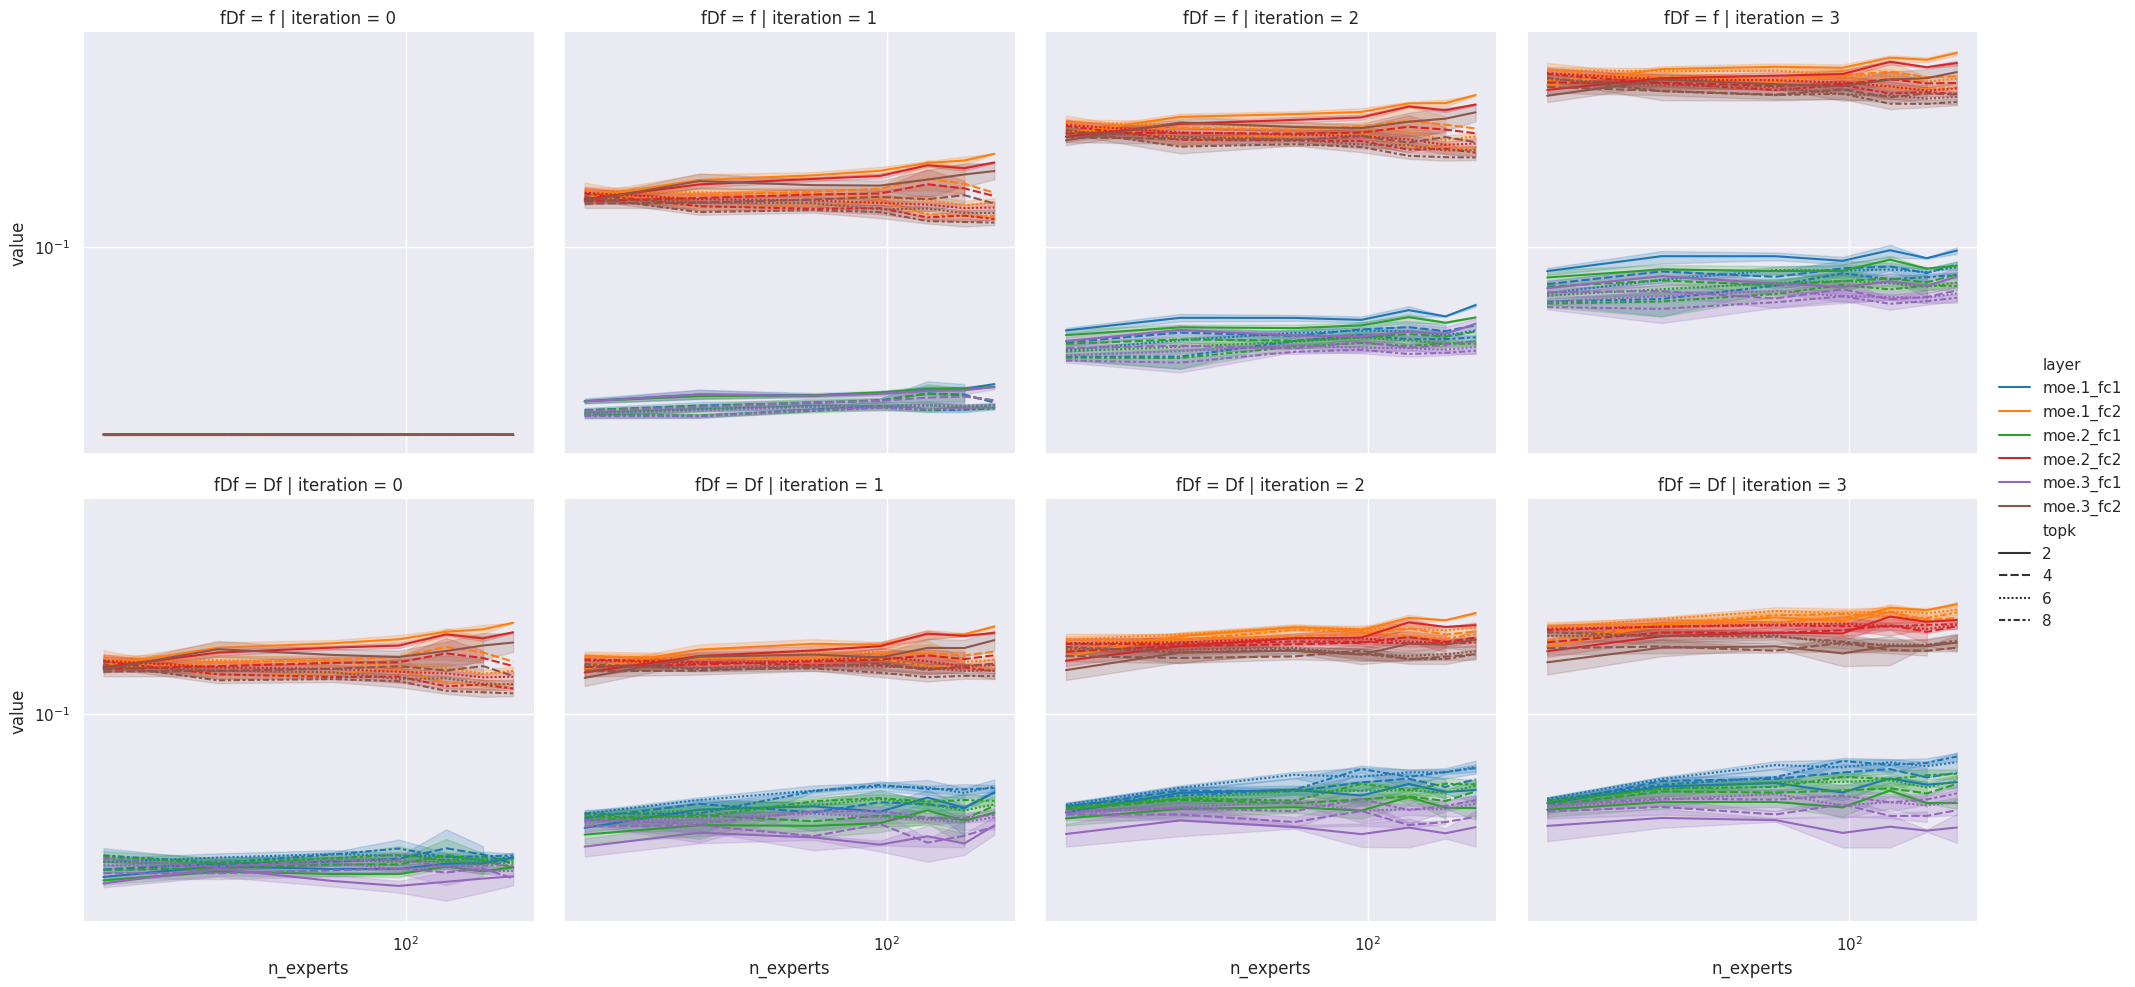

In [242]:
layer_type = "weight"
data_type = "norm"

# filtered = df[df["fDf"] == "Df"]
filtered = df
filtered = filtered[filtered["layer_type"] == layer_type]
filtered = filtered[filtered["data_type"] == data_type]
filtered = filtered[filtered["iteration"] < 4]
# filtered = filtered[filtered["iteration"] > 28]
filtered = filtered[filtered["layer"] != "output"]

# ouput_rows = filtered['layer'].str.contains("lm_head")
# filtered.loc[ouput_rows, 'value'] = filtered.loc[ouput_rows, 'value'] / (filtered.loc[ouput_rows, 'width'] / 256)**(1/2)

# lm_head weights are intentionally too big and have a multiplier applied during forward passes
# lm_head_rows = filtered['layer'].str.contains("lm_head")
# filtered.loc[lm_head_rows, 'value'] = filtered.loc[lm_head_rows, 'value'] / filtered.loc[lm_head_rows, 'width']

# # if layer_type == "input":
# filtered = filtered[filtered['layer'].str.contains("attn.c_proj")]
# else:
# filtered = filtered[filtered['layer'].str.contains("gating")]
filtered = filtered[filtered['layer'].str.contains("moe")]
# multiply "moe.{i}_fc2" layers by topk, but only if "fDf" == "Df"

# SGD
# moe_fc1_rows = filtered['layer'].str.contains("fc1") & filtered['layer'].str.contains("fc") & (filtered['fDf'] == "Df")
# filtered.loc[moe_fc1_rows, 'value'] = filtered.loc[moe_fc1_rows, 'value'] / filtered.loc[moe_fc1_rows, 'topk']**(1/2) * filtered.loc[moe_fc1_rows, 'n_experts']
# moe_fc2_rows = filtered['layer'].str.contains("fc2") & filtered['layer'].str.contains("fc") & (filtered['fDf'] == "Df")
# filtered.loc[moe_fc2_rows, 'value'] = filtered.loc[moe_fc2_rows, 'value'] * filtered.loc[moe_fc2_rows, 'topk']**(3/2) * filtered.loc[moe_fc2_rows, 'n_experts']

# Adam?
moe_fc1_rows = filtered['layer'].str.contains("fc1") & filtered['layer'].str.contains("fc") & (filtered['fDf'] == "Df")
filtered.loc[moe_fc1_rows, 'value'] = filtered.loc[moe_fc1_rows, 'value'] * filtered.loc[moe_fc1_rows, 'topk']**(1/4)
# moe_fc2_rows = filtered['layer'].str.contains("fc2") & filtered['layer'].str.contains("fc") & (filtered['fDf'] == "Df")
# filtered.loc[moe_fc2_rows, 'value'] = filtered.loc[moe_fc2_rows, 'value'] * filtered.loc[moe_fc2_rows, 'n_experts']**(1/2)

# filtered.loc[moe_fc2_rows, 'value'] = filtered.loc[moe_fc2_rows, 'value'] / filtered.loc[moe_fc2_rows, 'n_experts']**(1/2)
# filtered.loc[moe_fc2_rows, 'value'] = filtered.loc[moe_fc2_rows, 'value'] * (filtered.loc[moe_fc2_rows, 'n_experts'])**(1/2) / filtered.loc[moe_fc2_rows, 'topk']**(1/2)

# attn_c_q_rows = filtered['layer'].str.contains("attn.c_q")
# filtered.loc[attn_c_q_rows, 'value'] = filtered.loc[attn_c_q_rows, 'value'] #* (filtered.loc[attn_c_q_rows, 'width'])

# filtered.loc[:, 'value'] = filtered['value'] * (filtered['width'])**(1/2)

# c_rows = filtered['layer'].str.contains("attn.c_kv")
# filtered.loc[c_rows, 'value'] /= (filtered.loc[c_rows, 'width'] / 256)**(1/3)

# filtered[filtered['layer'].str.contains("c_proj")] *= (filtered[filtered['layer'].str.contains("c_proj")]['width'] / 256)**(1/2)

drop_cols = ["layer_type", "data_type"]
filtered = filtered.drop(columns=drop_cols)

p = sns.relplot(
    data=filtered,
    row="fDf",
    style="topk",
    y="value",
    x="n_experts",
    hue="layer",
    col="iteration",
    kind="line",
    palette="tab10"
)

# p.set(ylim=[0.0, 0.02])
p.set(yscale='log', xscale='log')
# p.set(xscale='log')
# p.set_axis_labels(
#     "n_experts", 
#     f"{layer_type.capitalize()} {data_type.capitalize()}"
# )

In [71]:
# Find the log-log slope of the fDf = Df lines for each iteration and each topk as a function of n. Use numpy to find the fit

import numpy as np
slope_data = []
for layer in filtered['layer'].unique():
    for topk in filtered['topk'].unique():
        print(f"Layer: {layer}, Topk: {topk}")
        for iteration in filtered['iteration'].unique():
            subset = filtered[
                (filtered['fDf'] == 'Df') &
                (filtered['topk'] == topk) &
                (filtered['iteration'] == iteration) &
                (filtered['layer'] == layer)
            ]
            if len(subset) < 2:
                continue
            x = subset['n_experts'].values
            y = subset['value'].values
            log_x = np.log(x)
            log_y = np.log(y)
            slope, intercept = np.polyfit(log_x, log_y, 1)
            slope_data.append({
                'fDf': 'Df',
                'iteration': iteration,
                'layer': layer,
                'topk': topk,
                'slope': slope,
                'intercept': intercept
            })
            print(f"iteration: {iteration}. slope: {slope:.4f}")

Layer: fc.0, Topk: 8
iteration: 0. slope: 0.0128
iteration: 1. slope: -0.0450
iteration: 2. slope: 0.0105
iteration: 3. slope: 0.0062
Layer: fc.0, Topk: 4
iteration: 0. slope: 0.0299
iteration: 1. slope: -0.0171
iteration: 2. slope: -0.0040
iteration: 3. slope: 0.0215
Layer: fc.0, Topk: 2
iteration: 0. slope: -0.0105
iteration: 1. slope: -0.0081
iteration: 2. slope: 0.0155
iteration: 3. slope: -0.0186
Layer: fc.0, Topk: 6
iteration: 0. slope: -0.0094
iteration: 1. slope: -0.0301
iteration: 2. slope: -0.0454
iteration: 3. slope: -0.0012
Layer: moe.1_fc1, Topk: 8
iteration: 0. slope: 0.2851
iteration: 1. slope: 0.2160
iteration: 2. slope: 0.1987
iteration: 3. slope: 0.1777
Layer: moe.1_fc1, Topk: 4
iteration: 0. slope: 0.3732
iteration: 1. slope: 0.3057
iteration: 2. slope: 0.2716
iteration: 3. slope: 0.2567
Layer: moe.1_fc1, Topk: 2
iteration: 0. slope: 0.4095
iteration: 1. slope: 0.3807
iteration: 2. slope: 0.3684
iteration: 3. slope: 0.3167
Layer: moe.1_fc1, Topk: 6
iteration: 0. slop

In [72]:
slope_data = []
for layer in filtered['layer'].unique():
    for n_expert in filtered['n_experts'].unique():
        print(f"Layer: {layer}, n_expert: {n_expert}")
        for iteration in filtered['iteration'].unique():
            subset = filtered[
                (filtered['fDf'] == 'Df') &
                (filtered['n_experts'] == n_expert) &
                (filtered['iteration'] == iteration) &
                (filtered['layer'] == layer)
            ]
            if len(subset) < 2:
                continue
            x = subset['topk'].values
            y = subset['value'].values
            log_x = np.log(x)
            log_y = np.log(y)
            slope, intercept = np.polyfit(log_x, log_y, 1)
            slope_data.append({
                'fDf': 'Df',
                'iteration': iteration,
                'layer': layer,
                'n_experts': n_expert,
                'slope': slope,
                'intercept': intercept
            })
            print(f"iteration: {iteration}. slope: {slope:.4f}")

Layer: fc.0, n_expert: 16
iteration: 0. slope: -0.0836
iteration: 1. slope: -0.0568
iteration: 2. slope: 0.0308
iteration: 3. slope: -0.0640
Layer: fc.0, n_expert: 96
iteration: 0. slope: -0.0033
iteration: 1. slope: 0.0059
iteration: 2. slope: 0.0772
iteration: 3. slope: -0.1784
Layer: fc.0, n_expert: 160
iteration: 0. slope: 0.0011
iteration: 1. slope: 0.0504
iteration: 2. slope: -0.0678
iteration: 3. slope: 0.1317
Layer: fc.0, n_expert: 288
iteration: 0. slope: -0.1007
iteration: 1. slope: -0.0860
iteration: 2. slope: 0.0181
iteration: 3. slope: -0.0880
Layer: fc.0, n_expert: 64
iteration: 0. slope: -0.0708
iteration: 1. slope: -0.1091
iteration: 2. slope: -0.0577
iteration: 3. slope: -0.1257
Layer: fc.0, n_expert: 256
iteration: 0. slope: 0.0529
iteration: 1. slope: -0.0470
iteration: 2. slope: 0.1383
iteration: 3. slope: 0.0263
Layer: fc.0, n_expert: 128
iteration: 0. slope: 0.0111
iteration: 1. slope: -0.0160
iteration: 2. slope: -0.0454
iteration: 3. slope: -0.1516
Layer: fc.0, 

In [38]:
for 

SyntaxError: invalid syntax (1235331270.py, line 1)

In [8]:
df['n_experts']

0         256
1         256
2         256
3         256
4         256
         ... 
215287     32
215288     32
215289     32
215290     32
215291     32
Name: n_experts, Length: 215292, dtype: int64

In [11]:
import math
import torch

def spectral_norm_svd(A: torch.Tensor) -> float:
    # return torch.linalg.matrix_norm(A, ord=2)
    return torch.linalg.svdvals(A.to(torch.float32)).max()

def natural_spectral_norm(A: torch.Tensor, return_list=False) -> float | torch.Tensor:
    # return torch.linalg.matrix_norm(A, ord='fro')
    if len(A.shape) == 3:
        norms = []
        for matrix in A:
            norms.append(spectral_norm_svd(matrix) * math.sqrt(matrix.size(1) / matrix.size(0)))
        if return_list:
            return torch.tensor(norms)
        else:
            return torch.tensor(norms).mean()
    return spectral_norm_svd(A) * math.sqrt(A.size(1) / A.size(0))

In [12]:
topk = 16
n_embd = 1024
base_ffn_hidden_dim = 4 * 1024
n_experts = 5

In [13]:
data = []
for topk in [1, 2, 4, 8, 16]: 

    d_ffn = base_ffn_hidden_dim // topk

    denominator = (n_embd**(1/2) + d_ffn**(1/2))
    numerator_b = d_ffn**(1/2) / n_embd**(1/2)
    numerator_a = n_embd**(1/2) / d_ffn**(1/2)

    for seed in range(3):
        A = torch.nn.Parameter(torch.empty((n_experts, d_ffn, n_embd)))
        B = torch.nn.Parameter(torch.empty((n_experts, n_embd, d_ffn)))

        A.data.normal_(mean=0.0, std=numerator_a / denominator)
        B.data.normal_(mean=0.0, std=numerator_b / denominator)

        asn = natural_spectral_norm(A.data, return_list=True).mean()
        bsn = natural_spectral_norm(B.data, return_list=True).mean()

        data.append({
            "topk": topk,
            "matrix": "A",
            "sn": asn.item(),
            "seed": seed
        })

        data.append({
            "topk": topk,
            "matrix": "B",
            "sn": bsn.item(),
            "seed": seed
        })

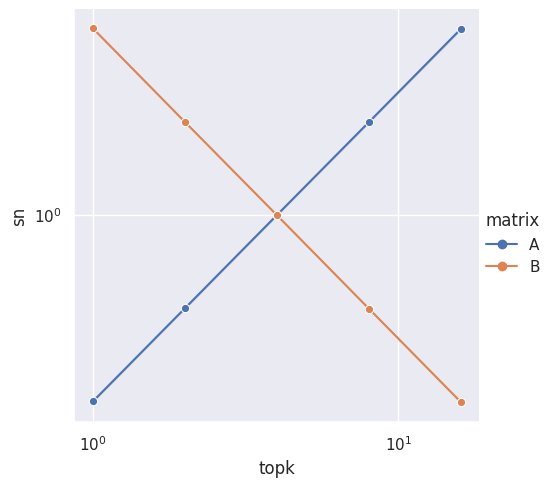

In [37]:
p = sns.relplot(
    data=pd.DataFrame(data),
    x="topk",
    y="sn",
    hue="matrix",
    kind="line",
    marker="o",
)
p.set(yscale='log')
p.set(xscale='log')

Okay, so this means something is either going wrong when I measure the spectral norm or when I initialize the weights...